In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import xarray as xr

import seawater as sw

import utils
import regrid_tools
import calc

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(36) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.63:33453 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
pth = '/glade/p/cgd/oce/projects/cesm2-marbl/woa2018-data-1x1'
ds_list = []
for v in ['t', 's']:
    files = [f'{pth}/woa18_decav_{v}{m:02d}_01.nc' for m in range(1, 13)]
    assert all([os.path.exists(f) for f in files])
    with xr.open_mfdataset(files, decode_times=False) as ds:
        ds_list.append(ds.load()[[f'{v}_an']])
ds = xr.merge(ds_list).rename({'t_an': 'TEMP', 's_an': 'SALT', 'depth': 'z_t', 'time': 'month'})
ds['month'] = np.arange(1, 13, 1)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, month: 12, z_t: 57)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * z_t      (z_t) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TEMP     (month, z_t, lat, lon) float32 nan nan nan ... -0.436 -0.436 -0.436
    SALT     (month, z_t, lat, lon) float32 nan nan nan ... 34.99 34.99 34.99

In [10]:
%%time
dso_1x1 = xr.Dataset()
dso_1x1['mld_125'] = calc.mld_dsigma(ds.SALT, ds.TEMP, dsigma=0.125, rho_chunks={'lat': 18, 'lon': 18}).compute()
dso_1x1['mld_030'] = calc.mld_dsigma(ds.SALT, ds.TEMP, dsigma=0.03, rho_chunks={'lat': 18, 'lon': 18}).compute()
dso_1x1

distributed.scheduler - ERROR - Couldn't gather keys {"('_interp_mld-5aef4a166868e0abe0da2bb3b2c5221c-<this-array>', 0, 2, 15)": []} state: ['memory'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('_interp_mld-5aef4a166868e0abe0da2bb3b2c5221c-<this-array>', 0, 2, 15)
NoneType: None


CPU times: user 8.93 s, sys: 2.35 s, total: 11.3 s
Wall time: 2min 37s


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, month: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mld_125  (month, lat, lon) float64 nan nan nan nan ... 7.393 7.393 7.393
    mld_030  (month, lat, lon) float64 nan nan nan nan ... 1.774 1.774 1.774

In [11]:
import pop_tools
rho = pop_tools.eos(ds.SALT.chunk({'z_t': 10}), 
                    ds.TEMP.chunk({'z_t': 10}), 
                    depth=ds.SALT.z_t * 0.).compute()
rho

<xarray.DataArray 'density' (month: 12, z_t: 57, lat: 180, lon: 360)>
array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1023.30848712, 1023.33096647, 1023.33971676, ...,
          1023.29955503, 1023.31731559, 1023.3035335 ],
         [1023.49437753, 1023.48944809, 1023.50355838, ...,
          1023.49038731, 1023.48138602, 1023.49192937],
         [1023.90513351, 1023.90513351, 1023.90513351, ...,
          1023.90513351, 1023.90513351, 1023.90513351]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
...
         [1028.1172863 , 1028.11650225, 1028.11605513, ...,
          1028.11972852, 1028.11864451, 1028.117959  ],
         [1028.12023736, 1028.12002089, 1028.11963273, ...,
          1028.12061838, 1028.12116717, 1028.1206602 ],
         [1028.12239609, 1028.12239609, 1028.12239609, ...,
          1028.12239609, 1028.12239609, 1028.12239609]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1028.11483665, 1028.11426688, 1028.11373165, ...,
          1028.11698478, 1028.11624904, 1028.11546317],
         [1028.11727218, 1028.11707805, 1028.1167303 , ...,
          1028.11871597, 1028.117898  , 1028.11741776],
         [1028.11827835, 1028.11827835, 1028.11827835, ...,
          1028.11827835, 1028.11827835, 1028.11827835]]]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * z_t      (z_t) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      kg/m^3
    long_name:  Density

<Figure size 288x432 with 0 Axes>

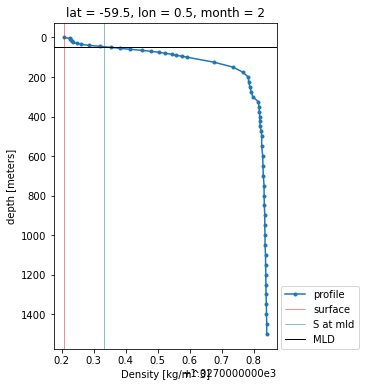

In [12]:
import matplotlib.pyplot as plt

dsigma = 0.125

plt.figure(figsize=(4, 6))
sel = dict(lat=-60, lon=0, month=2, method='nearest')

plt.figure(figsize=(4, 6))

rho.sel(**sel).plot(y='z_t', marker='.', linestyle='-', label='profile')

plt.axvline(rho.sel(**sel).isel(z_t=0), 
            linewidth=0.5, c='tab:red', label='surface')

plt.axvline(rho.sel(**sel).isel(z_t=0)+dsigma, 
            linewidth=0.5, c='tab:blue', label='S at mld')

#plt.axhline(dso_1x1.mld_125.sel(**sel), linewidth=1., c='k', label='MLD')
plt.axhline(np.interp(rho.sel(**sel).values[0]+0.125, rho.sel(**sel).values, ds.z_t.values), linewidth=1., c='k', label='MLD')

plt.legend(loc=(1.02, 0));
ylm = plt.ylim()
plt.ylim(ylm[::-1]);

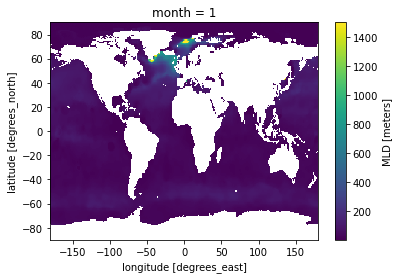

In [13]:
dso_1x1.mld_125.isel(month=0).plot()

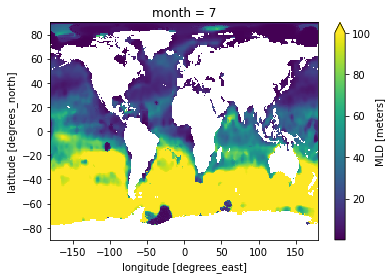

In [14]:
dso_1x1.mld_125.isel(month=6).plot(vmax=100)

In [15]:
dst_grid = regrid_tools.grid('POP_gx1v7', clobber=False)
src_grid = regrid_tools.grid('latlon_woa2018', nx=360, ny=180, lon0=-180.)

regridder = regrid_tools.regridder(src_grid, dst_grid, 'bilinear', clobber=False)
dso_model = xr.Dataset()
dso_model = regridder.regrid(dso_1x1, renormalize=True, apply_mask=False,).rename({'lat': 'nlat', 'lon': 'nlon'})
dso_model    

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_woa2018.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:  (month: 12, nlat: 384, nlon: 320)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    mld_125  (month, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    mld_030  (month, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

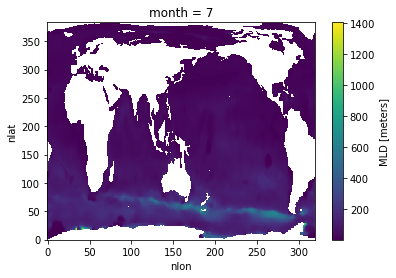

In [16]:
dso_model.mld_125.isel(month=6).plot()

In [17]:
dso_model.to_netcdf('/glade/p/cgd/oce/projects/cesm2-marbl/woa2018-data/POP_gx1v7/monthly/woa18_derived_MLD.nc')